In [25]:
#!pip install pyPRISMClimate
#!pip install hydrofunctions

In [2]:
import numpy as np
import pandas as pd
import rasterio as rio
from rasterio import plot, mask
import glob
import os
from pyPRISMClimate import get_prism_dailys
import matplotlib.pyplot as plt
import urllib
import geopandas as gpd
import hydrofunctions as hf
import xarray as xr
%matplotlib inline

In [3]:
# load dem
fork = 'nf'
in_asc_string = f'./dem_or_shapefile/final_{fork}_30m.asc'
out_gdal_string = f'./dem_or_shapefile/final_{fork}_30m.tif'
EPSG_code = 26710
dem_proj = f'EPSG:{EPSG_code}'

In [4]:
dem_src = rio.open(out_gdal_string)
dem_array = dem_src.read(1)

In [5]:
if not os.path.exists(out_gdal_string):
    !gdal_translate -of "GTiff" -a_srs EPSG:EPSG_code $in_asc_string $out_gdal_string

In [6]:
# function to download usgs stream data, basin
def get_basin_data(gaugeID, start_date, end_date, sf_filepath, featureSource = 'nwissite'):
    basin_url = f'https://labs.waterdata.usgs.gov/api/nldi/linked-data/{featureSource}/USGS-{gaugeID}/basin'
    
    # get shapefile of gauge basin
    basin_gdf = gpd.read_file(basin_url)
    
    # get streamflow at gauge
    streamflow = hf.NWIS(site=gaugeID, service='dv', start_date=start_date, end_date=end_date, file=sf_filepath)
    streamflow_df = streamflow.df()
    return basin_gdf, streamflow_df

everson_gdf, everson_streamflow = get_basin_data(gaugeID = '12211200', start_date = '2021-11-10', end_date = '2021-12-10', sf_filepath = 'discharge_data/everson.parquet')

Reading data from discharge_data/everson.parquet


<Axes: >

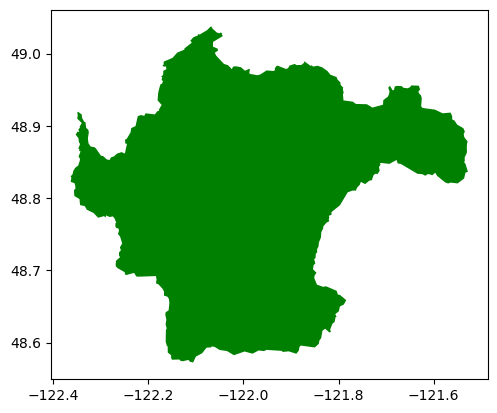

In [7]:
f, a = plt.subplots()
everson_gdf.plot(facecolor = 'green', ax=a)

In [19]:
# function to get weather data
def get_weather_for_watershed(start_date, end_date, destination, boundaries, varlist = ['ppt', 'tmean']):
   # this function will help keep track of the variable being downloaded and the date
    def get_variable_and_date(filename):
        filename = filename.split('_')
        variable, date = filename[-5], pd.to_datetime(filename[-2])
        return variable, date
        
    # download prism data
    for var in varlist:
        files = get_prism_dailys(var, min_date = start_date, 
                                 max_date = end_date, dest_path = destination,
                                 keep_zip=False)
    
        # makes a list of the weather files downloaded by above
        prism_file_paths = glob.glob(os.path.join(destination, '*.bil'))
        prism_file_paths.sort()
    
        #empty list of arrays
        arrays = []
    
        for file in prism_file_paths:
            # open file
            weather_file = rio.open(file)
        
            # mask file by watershed extent
            rio_mask_kwargs = {'filled':False, 'crop':True, 'indexes':1}
            array, array_transform = rio.mask.mask(weather_file, everson_gdf.to_crs(weather_file.crs).geometry, 
                                               **rio_mask_kwargs)
        
            lon = []
            lat = []
        
            # transform pixel positions to latitude and longitude for xarray coordinates using the affine transform
            for i in range(array.shape[0]):
                x, y = rio.transform.xy(array_transform, i, 0)
                lon = np.append(lon, y)
        
            for j in range(array.shape[1]):
                x, y = rio.transform.xy(array_transform, 0, j)
                lat = np.append(lat, x)
        
            variable, date = get_variable_and_date(file)
        
            # turn array into xarray to accomodate more dimensions
            array = xr.DataArray(array, 
                                 dims = ('x', 'y'), 
                                 coords = {'x': lon, 'y': lat})
        
            # add date dimension
            array = array.expand_dims(dim = 'date')
            array.coords['date'] = ('date', [date])
        
            # add variable dimension
            #array = array.expand_dims(dim = 'variable')
            #array.coords['variable'] = ('variable', [variable])
        
            arrays.append(array)
        
            # remove file (memory management), comment this line out if you'd like to preserve
            os.remove(file)
    
        globals()[f'dataset_{variable}'] = xr.concat(arrays, 'date')
    return dataset_ppt, dataset_tmean

test_file_ppt, test_file_tmean = get_weather_for_watershed('2021-11-10', '2021-12-10', 'precip_data/', everson_gdf)

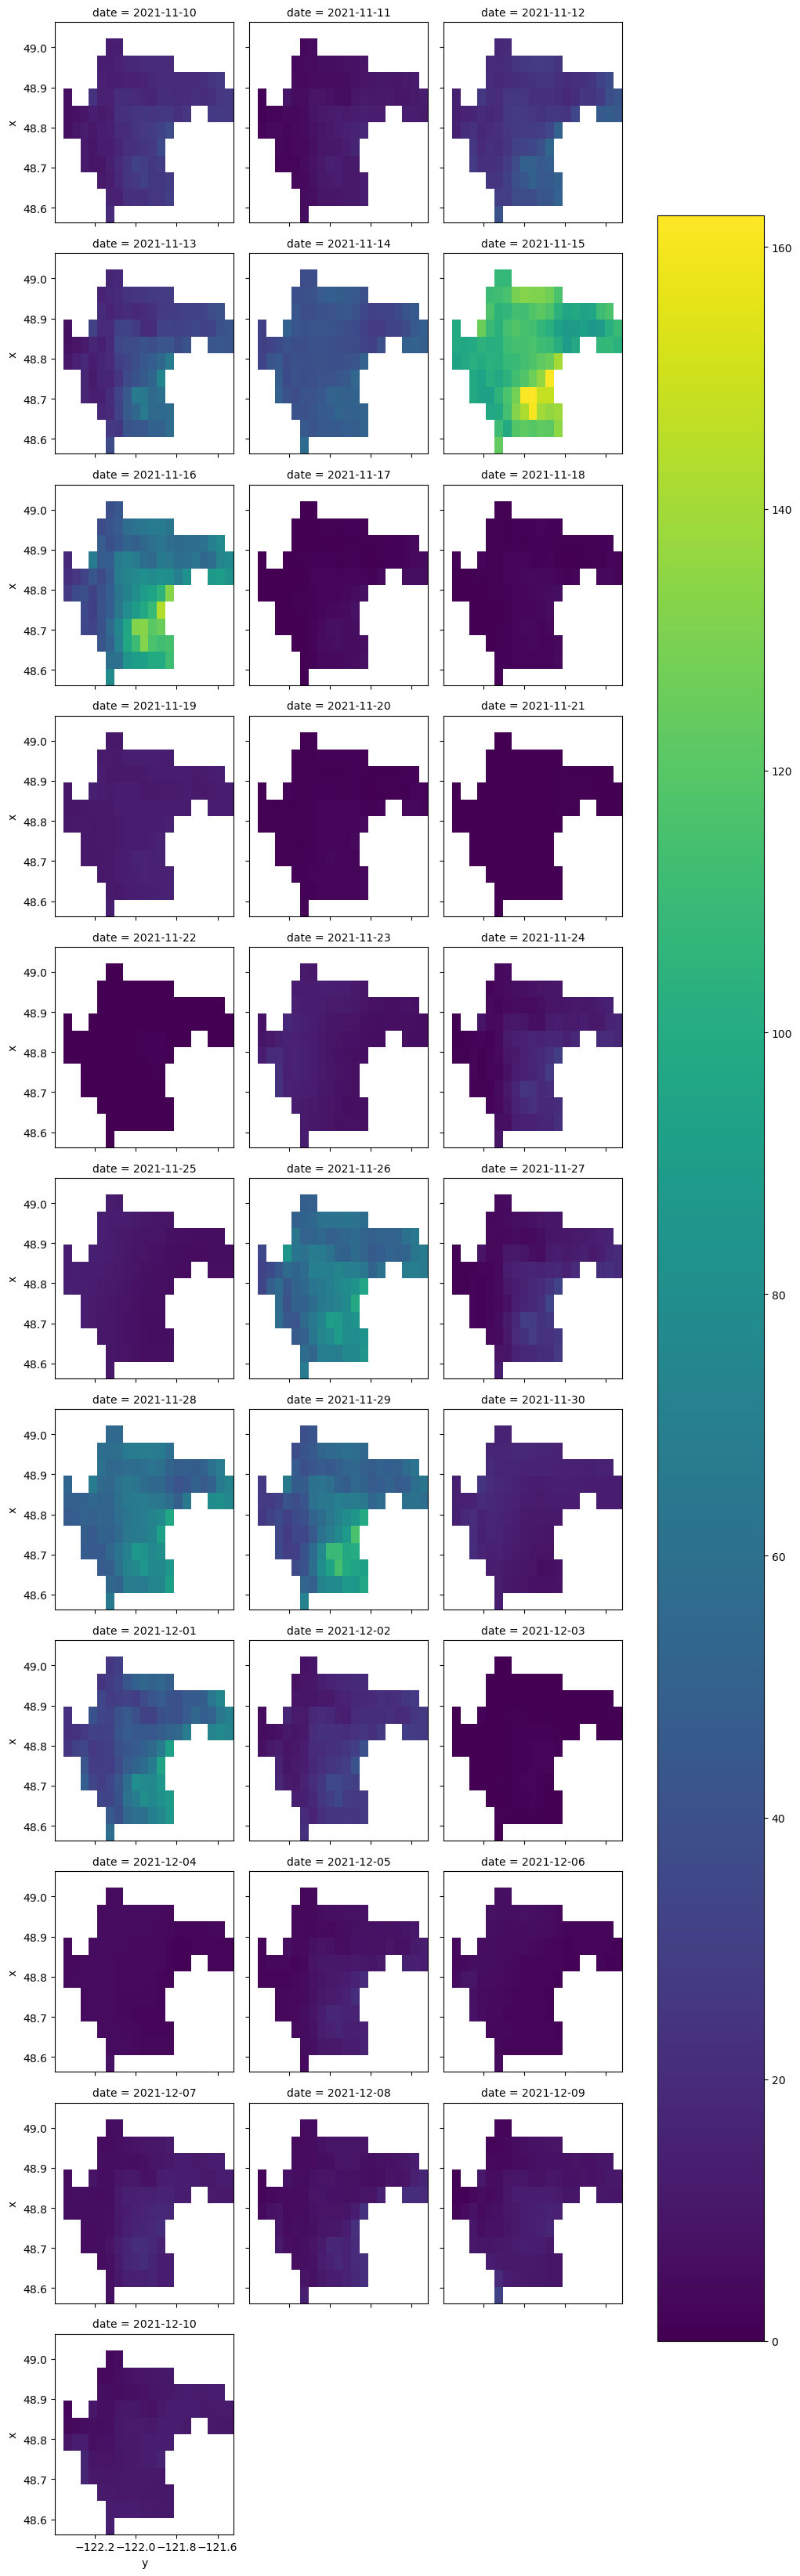

In [21]:
test_file_ppt.isel(date=slice(0, 31, 1)).plot.imshow(col = 'date', col_wrap = 3)

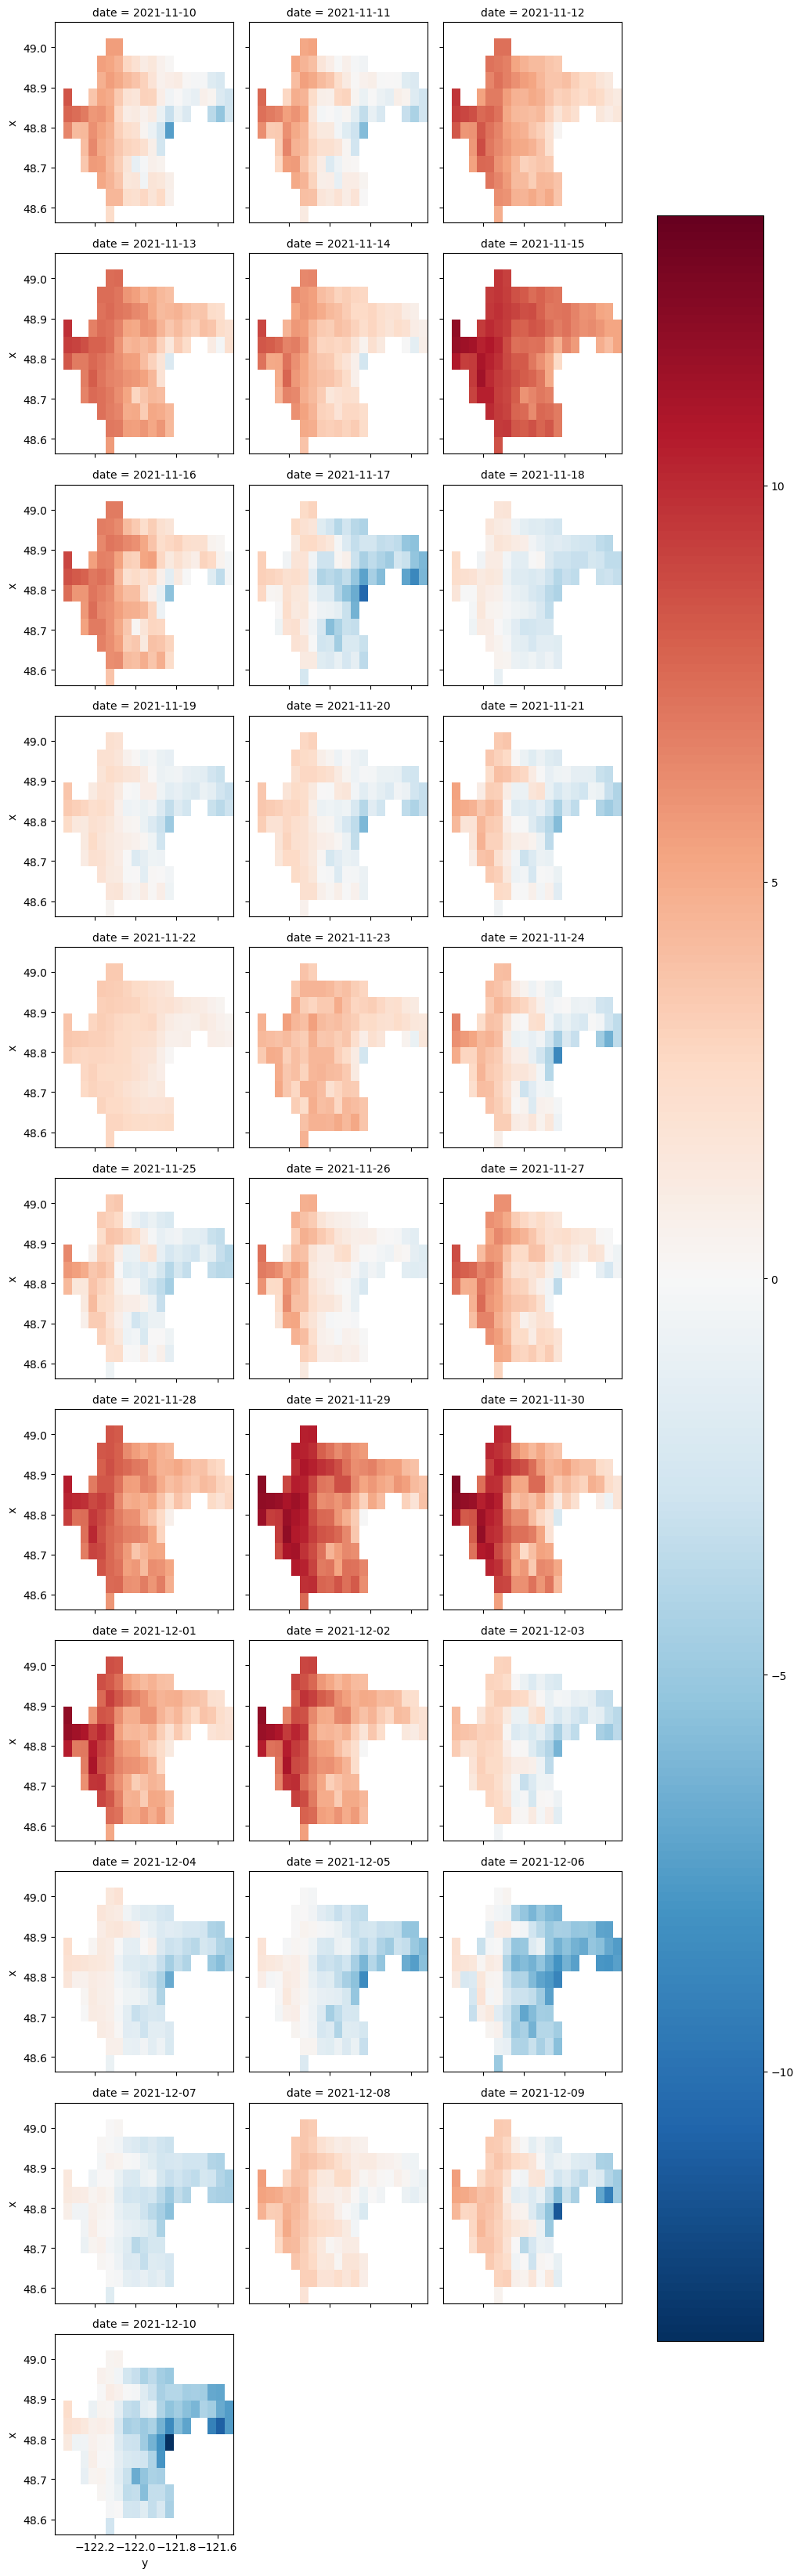

In [24]:
test_file_tmean.isel(date=slice(0, 31, 1)).plot.imshow(col = 'date', col_wrap = 3)

In [ ]:
# get infiltration data - potentially could put it together via gSSURGO or land use files

In [ ]:
# get SNOTEL data
# ulmo!

In [ ]:
# 